In [26]:
import numpy as np
import matplotlib.pyplot as plt

#for GP
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, DotProduct

Obs: things to change/review
- is v the margin? Inside userclass is ok? or better to fix it in the environment?
- call daily costs as cost or costs inside classes? for now Im' mixing
- saving collected_rewards as np.array is a waste of resource

- on step1:
    - n_arms in evironment class is redundant 
    - rename Environment class with PricingEnvironment 

- on step2:
    - delete margin parameter in the function update() in class GPTS, it is useless


User Class

In [27]:
class UserClass:
    """
    F1 and F2: in {0,1}
        are the binary features
    v: positive number
        is the value per click
    click_function: it is a function
        represents the number of clicks given a bid
    cost_function: it is a function
        represents the cost given a bid
    conversion_rate: a function with image in [0,1] (com: usually descendent)
        it represent how a user is likely to buy the product given a price
        Obs:
        |   in the text says to consider just 5 prices, maybe we can consider this as an array instead of a function
        |__

    """

    def __init__(self, F1, F2, v, click_function, cost_function, conversion_rate_function):
        self.v = v
        self.F1 = F1
        self.F2 = F2
        self.click_function = click_function
        self.cost_function = cost_function
        self.conversion_rate_function = conversion_rate_function



Basic Learner

In [28]:
class Learner:
    """
    Atributes:
    (....)
    rewards_per_arm: a list of list of dimension: number_of_arms x self.t

    (....)
    """

    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.t = 0 #current round
        self.rewards_per_arm = x = [[] for i in range(n_arms)]
        self.collected_rewards = np.array([])

    def pull_arm(self):
        pass

    def update_observations(self, pulled_arm, reward):
        self.rewards_per_arm[pulled_arm].append(reward)
        self.collected_rewards = np.append(self.collected_rewards, reward)



# Step 1

-we are just considering one class of users
<br>
-n and c are known
\
-alpha is unknown

### Environment

In [29]:
class Environment:

    def __init__(self, n_arms, prices, user_class):
        """
        n_arms: integer

        prices: array
            it is the set of prices we will use, since we are discretizing the problem
            eg: an array of 5
        """
        self.n_arms = n_arms# = len(prices)
        self.prices = prices
        self.user_class = user_class


        self.convertion_probabilities = [user_class.conversion_rate_function(p) for p in prices]


    def round(self, n_daily_clicks, margin, cum_daily_costs, pulled_arm_price):
        #OBS:
        # The conversion probability is the probability of buying the item given a price, thus is a Bernoulli probabilty

        alpha = self.convertion_probabilities[pulled_arm_price]
        #here sampled reward
        reward = np.random.binomial(n_daily_clicks, alpha) * margin - cum_daily_costs
        # if reward in expextation: reward = n_daily_clicks * alpha * margin - cum_daily_costs

        return reward

### Learners

Obs: here the arms are for the prices

In [30]:
class UCB1_Learner(Learner):

    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.empirical_means = np.zeros(n_arms)
        self.confidence = np.full(n_arms, np.inf)


    def pull_arm(self):
        upper_confidence = self.empirical_means + self.confidence
        idx = np.random.choice(np.where(upper_confidence == upper_confidence.max())[0])
        return idx

    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)
        
        self.empirical_means[pulled_arm] = ((self.t - 1) * self.empirical_means[pulled_arm] + reward) / self.t

        for a in range(self.n_arms):
            n_samples = len(self.rewards_per_arm[a])

            if n_samples > 0:
                c = np.sqrt(2)
                self.confidence[a] = c * np.sqrt(np.log(self.t)/n_samples)

        


class Custom_UCB_Learner(UCB1_Learner):

    def __init__(self, n_arms, n):#n = number of clicks
        super().__init__(n_arms)
        self.n = n


    def update(self, pulled_arm, reward, cost, margin):
        self.t += 1
        self.update_observations(pulled_arm, reward)
        
        #update mean
        self.empirical_means[pulled_arm] = ((self.t - 1) * self.empirical_means[pulled_arm] + reward) / self.t
        
        #update confidences
        for a in range(self.n_arms):
            n_samples = len(self.rewards_per_arm[a])

            if n_samples > 0:
                c = self.n * np.sqrt(2)
                self.confidence[a] = c * np.sqrt(np.log(self.t)/n_samples) * margin - cost

        

In [31]:
# from Learner import *

class Binomial_TS_Learner(Learner):
    """
    prior: P(p) as Beta(alpha, beta)
    likelihood: p(k|p;n) =  Binomial(n,p)

    By Bayes, we have that:
        posterior: p(p|k;n) = Beta(alpha+k, beta+n-k)
        

    Note:
        - This algorithm learns p assuming n is known (n is the maximum value k can assume)
        - In this simple scenario thr reward we observe is k
    """

    def __init__(self, n_arms, n):
        super().__init__(n_arms)
        self.beta_parameters = np.ones((n_arms, 2))
        self.n = n


    def pull_arm(self):
        idx = np.argmax(np.random.beta( self.beta_parameters[:,0], self.beta_parameters[:,1] ))
        return idx

    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)

        self.beta_parameters[pulled_arm,0] = self.beta_parameters[pulled_arm,0] + reward
        self.beta_parameters[pulled_arm,1] = self.beta_parameters[pulled_arm,1] + self.n - reward



class Custom_TS_Learner(Binomial_TS_Learner):
    def __init__(self, n_arms, n):
        super().__init__(n_arms, n)


    # def from_reward_to_k(reward, cost, margin):
    #     k = (reward + cost)/margin
    #     return k

    def update(self, pulled_arm, reward, cost, margin):
        self.t += 1
        self.update_observations(pulled_arm, reward)

        k = (reward + cost) / margin#self.from_reward_to_k(cost,margin)
        self.beta_parameters[pulled_arm,0] = self.beta_parameters[pulled_arm,0] + k
        self.beta_parameters[pulled_arm,1] = self.beta_parameters[pulled_arm,1] + self.n - k



## Example

In [32]:
F1 = 0
F2 = 0
v = 3
def click_f(bid):
    bid_0 = 2
    bid_1 = 6
    max_clicks = 5

    # if bid < bid_0:
    #     return 0
    # elif bid < bid_1:
    #     return n_max * (bid - bid_0)/(bid_1-bid_0)
    # return n_max


    return (bid < bid_1) * (bid > bid_0) * (bid - bid_0)/(bid_1-bid_0) * max_clicks + (bid >= bid_1) * max_clicks



def cost_f(bid):
    return bid * 2

def conversion_rate_f(price):
    return np.exp(-price)

def conversion_rate_f(price):
    return np.exp(-price)

C1 = UserClass(F1, F2, v, click_f, cost_f, conversion_rate_f)

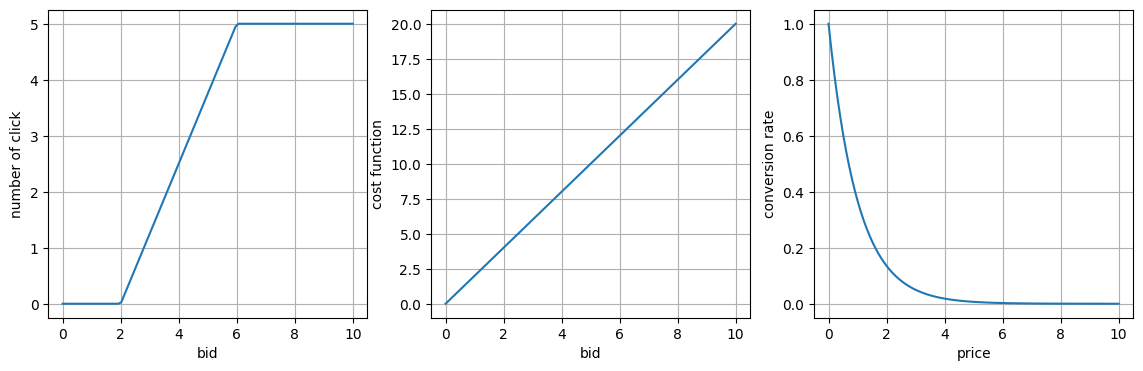

In [33]:
plt.figure(figsize=(14,4))

xx = np.linspace(0,10,100)
plt.subplot(1,3,1)
plt.plot(xx, click_f(xx))
plt.xlabel('bid')
plt.ylabel('number of click')
plt.grid(True)

xx = np.linspace(0,10,100)
plt.subplot(1,3,2)
plt.plot(xx, cost_f(xx))
plt.xlabel('bid')
plt.ylabel('cost function')
plt.grid(True)

xx = np.linspace(0,10,100)
plt.subplot(1,3,3)
plt.plot(xx, conversion_rate_f(xx))
plt.xlabel('price')
plt.ylabel('conversion rate')
plt.grid(True)

In [34]:
#Fixed parameters
n_arms = 5
T = 365

# in this step n_clicks and cost are given
# so let's fix a bid and compute n_clicks and cost
BID = 6
n_daily_clicks = C1.click_function(BID)
cum_daily_costs = C1.cost_function(BID)

margin = 90


#setting the arms
prices = np.array([1,3,5,7,9])
opt_arm = np.argmax(C1.conversion_rate_function(prices)) #optimal value of convertion rate between the arms
opt = n_daily_clicks * C1.conversion_rate_function(prices[opt_arm]) * margin - cum_daily_costs

### UCB

In [35]:
## UCB learner

n_experiments = 1000
ucb_rewards_per_experiment = []

for e in range(0, n_experiments):
    # print(f'{e/n_experiments*100}%')

    env = Environment(n_arms, prices, C1)
    ucb_learner = Custom_UCB_Learner(n_arms,n_daily_clicks)

    rewards_single_experiment = []
    for t in range(0, T):
        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(n_daily_clicks, margin, cum_daily_costs, pulled_arm)
        ucb_learner.update(pulled_arm, reward,cum_daily_costs, margin)

        rewards_single_experiment.append(reward)

    ucb_rewards_per_experiment.append(rewards_single_experiment)

### Thompson Sampling

In [36]:
## TS learner

n_experiments = 1000
ts_rewards_per_experiment = []

for e in range(0, n_experiments):
    # print(f'{e/n_experiments*100}%')

    env = Environment(n_arms, prices, C1)
    ts_learner = Custom_TS_Learner(n_arms,n_daily_clicks)

    rewards_single_experiment = []
    for t in range(0, T):
        pulled_arm = ts_learner.pull_arm()
        reward = env.round(n_daily_clicks, margin, cum_daily_costs, pulled_arm)
        ts_learner.update(pulled_arm, reward,cum_daily_costs, margin)

        rewards_single_experiment.append(reward)

    ts_rewards_per_experiment.append(rewards_single_experiment)

### Plots both methods

In [ ]:
std_inst = np.std(ucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(ucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(ucb_rewards_per_experiment, axis = 0)

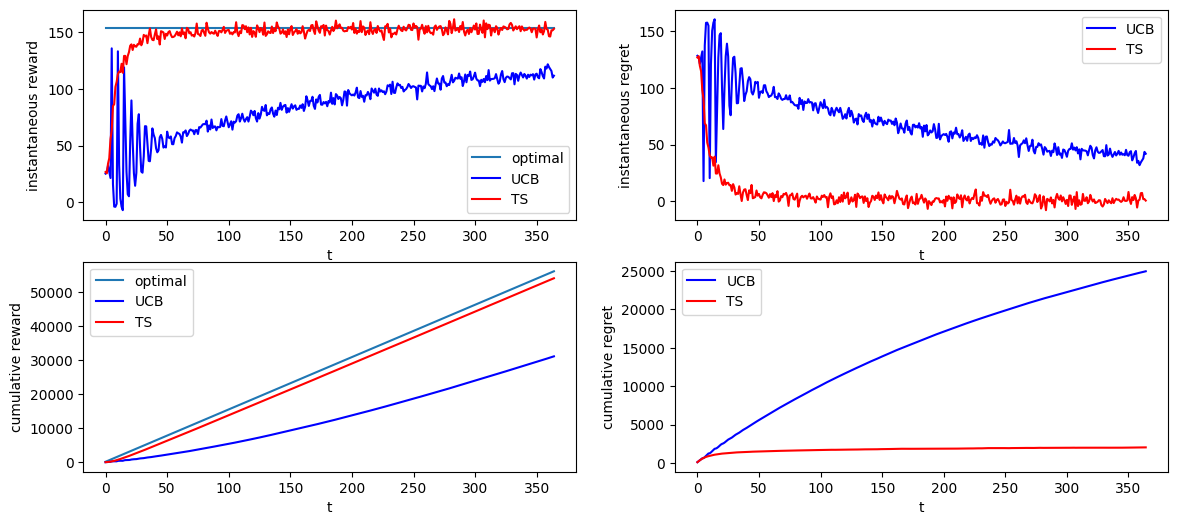

In [37]:
#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt))
plt.plot(np.mean(ucb_rewards_per_experiment, axis = 0), 'b')
plt.plot(np.mean(ts_rewards_per_experiment, axis = 0), 'r')
plt.legend(["optimal","UCB","TS"])

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(np.mean(opt - ucb_rewards_per_experiment, axis = 0), 'b')
plt.plot(np.mean(opt - ts_rewards_per_experiment, axis = 0), 'r')
plt.legend(["UCB","TS"])



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)))
plt.plot(np.cumsum(np.mean(ucb_rewards_per_experiment, axis = 0)), 'b')
plt.plot(np.cumsum(np.mean(ts_rewards_per_experiment, axis = 0)), 'r')
plt.legend(["optimal","UCB","TS"])

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis = 0)), 'b')
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis = 0)), 'r')
plt.legend(["UCB","TS"])

# Step 2

hp:
- just one class of users
- alpha is known
- n and c are unknown

In [ ]:
"""
OBS:
I'm assuming that we can see both the n_clicks and the daily cost of the advertising,
(other than the reward, that can be computed by having the n_clciks and the daily cost

obs:
but the reward is not necessary in the update of the learner, it is necessary only choose the arm to be pulled
so I'll use 2 GP-Bandit learners one for the reward and another one for the costs
"""

### Environment

In [ ]:
class BiddingEnvironment:
    def __init__(self, bids, user_class, sigma_clicks, sigma_costs):
        """
        n_arms: integer

        prices: array
            it is the set of prices we will use, since we are discretizing the problem
            eg: an array of 5
        """
        # self.n_arms = len(bids)
        self.bids = bids
        self.user_class = user_class

        self.mean_clicks = [user_class.click_function(b) for b in bids]
        self.mean_costs = [user_class.cost_function(b) for b in bids]

        self.sigmas_clicks = np.ones(len(bids)) * sigma_clicks
        self.sigmas_costs = np.ones(len(bids)) * sigma_costs


    def round(self, margin, conversion_rate, pulled_arm):
        #OBS:
        n_daily_clicks = np.random.normal(self.mean_clicks[pulled_arm], self.sigmas_clicks[pulled_arm])
        cum_daily_costs = np.random.normal(self.mean_costs[pulled_arm], self.sigmas_costs[pulled_arm])

        alpha = conversion_rate # or "np.random.binomial(n_daily_clicks, conversion_rate)" ? imo this complicates the learning
        reward = n_daily_clicks * alpha * margin - cum_daily_costs

        return n_daily_clicks, cum_daily_costs, reward

### Learners

GPUCB

In [ ]:
class GPUCB_Learner(Learner):
    def __init__(self, arms, kernel=None, alpha = 0.025):
        n_arms = len(arms)
        super().__init__(n_arms)

        self.arms = arms

        if kernel == None:
            kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3))#Obs: the hyperparamters will be optimized (changed) during learning

        self.means = np.zeros(n_arms)#np.full(n_arms, 1e3)
        self.sigmas = np.ones(n_arms)#np.full(n_arms, 1e3)#np.ones(n_arms)

        self.pulled_arms_x = []

        self.gp = GaussianProcessRegressor(kernel=kernel,
                                           alpha = alpha,
                                           n_restarts_optimizer = 4,
                                           normalize_y=True)


    def update_observations(self, arm_idx, reward):
        super().update_observations(arm_idx, reward)

        self.pulled_arms_x.append(self.arms[arm_idx])


    def pull_arm(self):
        upper_confidence = self.means + self.sigmas
        idx = np.random.choice(np.where(upper_confidence == upper_confidence.max())[0])
        return idx


    def update(self, arm, reward):
        """
        updates the values given the reward and the arm pulled
        """
        self.x = np.append(self.x, arm)
        self.y = np.append(self.y, reward)
        X = np.atleast_2d(self.x).T
        Y = self.y.ravel()

        self.gp.fit(X, Y)

        for key in self.values:
            y_pred, sigma = self.gp.predict(key, return_std = True)
            self.values[key] = y_pred
            self.ucb[key] = y_pred + sigma  #TODO don't knoiw if this is coerrect


    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)

        # update of the model:
        x = np.array(self.pulled_arms_x).reshape((-1,1))
        y = np.array(self.collected_rewards)

        if len(y) > 1:#at least 2 elements in our training set. (not sure why.. to update the kernel hyperparameters??)
            self.gp.fit(x,y)

        self.means, self.sigmas = self.gp.predict(np.array(self.arms).reshape((-1,1)), return_std=True)
        self.sigmas = np.maximum(self.sigmas, 1e-5)



class Custom_GPUCB_Learner(Learner):
    def __init__(self, arms):
        super().__init__(len(arms))

        self.clicks_gpucb_learner = GPUCB_Learner(arms)
        self.costs_gpucb_learner = GPUCB_Learner(arms)


    def pull_arm(self, conversion_rate, margin):
        sampled_clicks = np.random.normal(self.clicks_gpucb_learner.means, self.clicks_gpucb_learner.sigmas)
        sampled_costs = np.random.normal(self.costs_gpucb_learner.means, self.costs_gpucb_learner.sigmas)

        #upper bounds of clicks and lower bounds of costs
        ub_clicks = self.clicks_gpucb_learner.means + self.clicks_gpucb_learner.sigmas
        lb_costs = self.costs_gpucb_learner.means -  self.costs_gpucb_learner.sigmas

        alpha = conversion_rate
        upper_confidence = ub_clicks * alpha * margin - lb_costs
        idx = np.random.choice(np.where(upper_confidence == upper_confidence.max())[0])
        return idx

    def update(self, pulled_arm, n_daily_clicks, cum_daily_costs, reward):
        # com: actually reward is computable: reward = n_daily_clicks * alpha * margin - cum_daily_costs, where alpha = conversion_rate
        self.t += 1
        self.update_observations(pulled_arm, reward)

        self.clicks_gpucb_learner.update(pulled_arm, n_daily_clicks)
        self.costs_gpucb_learner.update(pulled_arm, cum_daily_costs)

GPTS

In [ ]:
class GPTS_Learner(Learner):
    def __init__(self, arms, kernel = None):
        super().__init__(len(arms))
        self.arms = arms

        n_arms = len(arms)
        self.means = np.zeros(n_arms)#np.full(n_arms, 1e3)
        self.sigmas = np.ones(n_arms)#np.full(n_arms, 1e3)#np.ones(n_arms)

        self.pulled_arms_x = []#here we will save the values of the pulled arms (not the indexes)

        if kernel == None:
            kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3))#Obs: the hyperparamters will be optimized (changed) during learning

        self.gp = GaussianProcessRegressor(kernel=kernel,
                                           alpha = 0.5**2,
                                           n_restarts_optimizer = 9,#the higher the slower the run, try 4
                                           normalize_y=True)


    def update_observations(self, arm_idx, reward):
        super().update_observations(arm_idx, reward)

        self.pulled_arms_x.append(self.arms[arm_idx])

    def pull_arm(self):
        sampled_values = np.random.normal(self.means, self.sigmas)
        idx = np.argmax(sampled_values)
        return idx

    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)

        # update of the model:
        x = np.array(self.pulled_arms_x).reshape((-1,1))
        y = np.array(self.collected_rewards)

        if len(y) > 1:#at least 2 elements in our training set. (not sure why.. to update the kernel hyperparameters??)
            self.gp.fit(x,y)

        self.means, self.sigmas = self.gp.predict(np.array(self.arms).reshape((-1,1)), return_std=True)
        self.sigmas = np.maximum(self.sigmas, 1e-2)



class Custom_GPTS_Learner(Learner):
    def __init__(self, arms):
        super().__init__(len(arms))

        self.clicks_gpts_learner = GPTS_Learner(arms)
        self.costs_gpts_learner = GPTS_Learner(arms)

    def pull_arm(self, conversion_rate, margin):
        sampled_clicks = np.random.normal(self.clicks_gpts_learner.means, self.clicks_gpts_learner.sigmas)
        sampled_costs = np.random.normal(self.costs_gpts_learner.means, self.costs_gpts_learner.sigmas)

        alpha = conversion_rate
        idx = np.argmax(sampled_clicks * alpha * margin - sampled_costs)
        return idx

    def update(self, pulled_arm, n_daily_clicks, cum_daily_costs, reward, margin):
        # com: actually reward is computable: reward = n_daily_clicks * alpha * margin - cum_daily_costs, where alpha = conversion_rate
        self.t += 1
        self.update_observations(pulled_arm, reward)


        self.clicks_gpts_learner.update(pulled_arm, n_daily_clicks)
        self.costs_gpts_learner.update(pulled_arm, cum_daily_costs)

## Example

In [ ]:
F1 = 0
F2 = 0
v = 3
def click_f(bid):
    bid_0 = 2
    bid_1 = 6
    max_clicks = 5

    # if bid < bid_0:
    #     return 0
    # elif bid < bid_1:
    #     return n_max * (bid - bid_0)/(bid_1-bid_0)
    # return n_max


    return (bid < bid_1) * (bid > bid_0) * (bid - bid_0)/(bid_1-bid_0) * max_clicks + (bid >= bid_1) * max_clicks



def cost_f(bid):
    return bid * 2

def conversion_rate_f(price):
    return np.exp(-price)

def conversion_rate_f(price):
    return np.exp(-price)

C1 = UserClass(F1, F2, v, click_f, cost_f, conversion_rate_f)

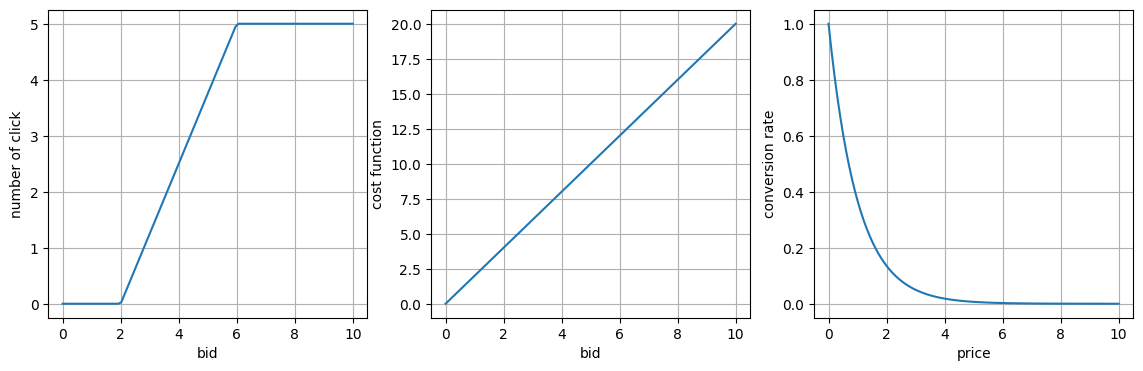

In [ ]:
plt.figure(figsize=(14,4))

xx = np.linspace(0,10,100)
plt.subplot(1,3,1)
plt.plot(xx, click_f(xx))
plt.xlabel('bid')
plt.ylabel('number of click')
plt.grid(True)

xx = np.linspace(0,10,100)
plt.subplot(1,3,2)
plt.plot(xx, cost_f(xx))
plt.xlabel('bid')
plt.ylabel('cost function')
plt.grid(True)

xx = np.linspace(0,10,100)
plt.subplot(1,3,3)
plt.plot(xx, conversion_rate_f(xx))
plt.xlabel('price')
plt.ylabel('conversion rate')
plt.grid(True)

Parameters

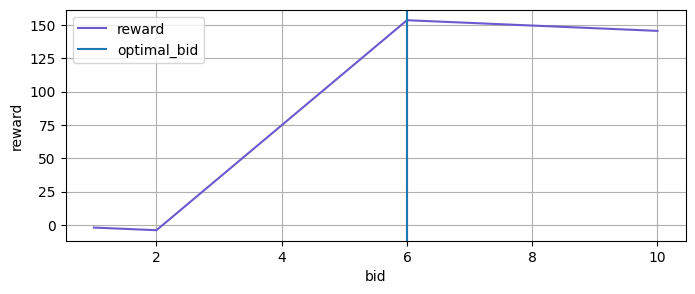

In [ ]:
#Fixed parameters
T = 100#365

# in this step the optimal price for the conversion rate is given,
# so let's fix the price and compute the releated conversion rate
PRICE = 1
conversion_rate = C1.conversion_rate_function(PRICE)

# margin
margin = 90

# sigmas
sigma_clicks = 0.5
sigma_costs = 0.3

#setting the arms
bids = np.linspace(1,10,100)

rewards_on_arms = C1.click_function(bids) * conversion_rate * margin - C1.cost_function(bids)
opt_arm = np.argmax(rewards_on_arms) #optimal value of convertion rate between the arms
opt = rewards_on_arms[opt_arm]

plt.figure(figsize=(8,3))
plt.plot(bids, rewards_on_arms, "slateblue")
plt.axvline(bids[opt_arm])
plt.xlabel('bid')
plt.ylabel('reward')
plt.legend(["reward","optimal_bid"])
plt.grid(True)

### UCB

In [ ]:
## UCB learner

n_experiments = 20
gpucb_rewards_per_experiment = []

gpucb_n_daily_clicks_hat = np.zeros(len(bids))
gpucb_n_daily_clicks_std = np.zeros(len(bids))

gpucb_cum_daily_costs_hat = np.zeros(len(bids))
gpucb_cum_daily_costs_std = np.zeros(len(bids))

# #to count the arms that are pulled
gpucb_pulled_arms_counter = np.zeros(len(bids))

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = BiddingEnvironment(bids, C1, sigma_clicks, sigma_costs)
    gpucb_learner = Custom_GPUCB_Learner(bids)

    rewards_single_experiment = []
    for t in range(0, T):
        pulled_arm = gpucb_learner.pull_arm(conversion_rate, margin)
        n_daily_clicks, cum_daily_costs, reward = env.round(margin, conversion_rate, pulled_arm)
        gpucb_learner.update(pulled_arm, n_daily_clicks, cum_daily_costs, reward)

        rewards_single_experiment.append(reward)
    gpucb_rewards_per_experiment.append(rewards_single_experiment)

    mean_prediction, std_prediction = gpucb_learner.clicks_gpucb_learner.gp.predict(bids.reshape((-1,1)), return_std=True)
    gpucb_n_daily_clicks_hat += mean_prediction / n_experiments
    gpucb_n_daily_clicks_std += std_prediction  / n_experiments

    mean_prediction, std_prediction = gpucb_learner.costs_gpucb_learner.gp.predict(bids.reshape((-1,1)), return_std=True)
    gpucb_cum_daily_costs_hat += mean_prediction / n_experiments
    gpucb_cum_daily_costs_std += std_prediction  / n_experiments

    # #counting the pulled arms
    gpucb_pulled_arms_counter += np.array([gpucb_learner.clicks_gpucb_learner.pulled_arms_x.count(bid) for bid in bids]) / n_experiments

0.0%


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


5.0%


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarni

10.0%


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarni

15.0%
20.0%
25.0%


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


30.0%


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


35.0%
40.0%


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


45.0%


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


50.0%


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


55.00000000000001%


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


60.0%
65.0%


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarni

70.0%


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


75.0%
80.0%


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


85.0%
90.0%


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


95.0%


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


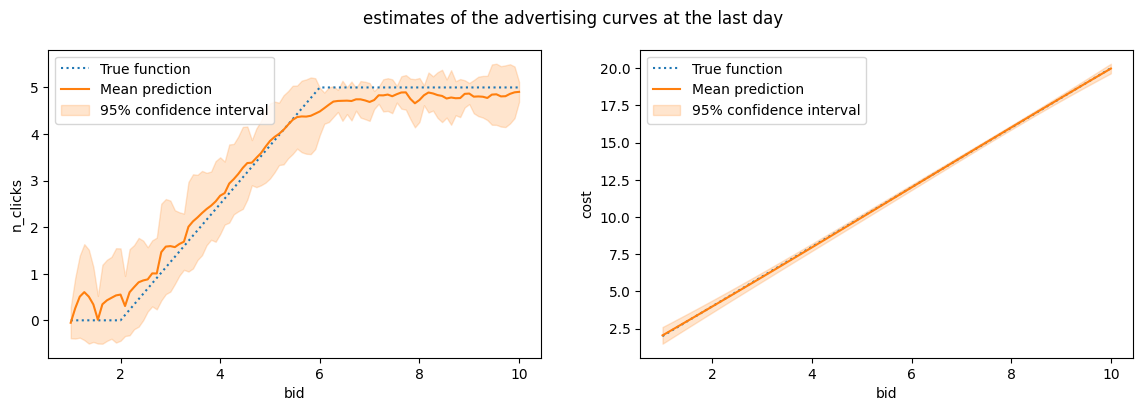

In [ ]:
# Plots of the estimates of the functions clicks and costs at the last day
plt.figure(figsize = (14,4))
plt.suptitle('estimates of the advertising curves at the last day')

plt.subplot(1,2,1)
plt.plot(bids,C1.click_function(bids), linestyle="dotted", label = "True function")
plt.plot(bids, gpucb_n_daily_clicks_hat, color = "C1",label="Mean prediction")
plt.fill_between(bids, gpucb_n_daily_clicks_hat - 1.96 *gpucb_n_daily_clicks_std, gpucb_n_daily_clicks_hat + 1.96*gpucb_n_daily_clicks_std,
                 alpha = 0.2, color="tab:orange", label=r"95% confidence interval")
plt.xlabel("bid")
plt.ylabel("n_clicks")
plt.legend()

plt.subplot(1,2,2)
plt.plot(bids,C1.cost_function(bids), linestyle="dotted", label = "True function")
plt.plot(bids, gpucb_cum_daily_costs_hat, color = "C1",label="Mean prediction")
plt.fill_between(bids, gpucb_cum_daily_costs_hat - 1.96 *gpucb_cum_daily_costs_std, gpucb_cum_daily_costs_hat + 1.96*gpucb_cum_daily_costs_std,
                 alpha = 0.2, color="tab:orange", label=r"95% confidence interval")
plt.xlabel("bid")
plt.ylabel("cost")
plt.legend()

In [ ]:
# #Plots
# plt.figure(figsize = (14,4))

# plt.subplot(1,2,1)
# plt.xlabel("t")
# plt.ylabel("rewards")
# plt.plot(np.arange(T), np.full(T,opt))
# plt.plot(np.mean(ucb_rewards_per_experiment, axis = 0), 'r')
# plt.legend(["optimal","UCB"])

# plt.subplot(1,2,2)
# plt.xlabel("t")
# plt.ylabel("cumulative regret")
# plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis = 0)), 'r')
# plt.legend(["UCB"])

Text(0, 0.5, 'times pulled')

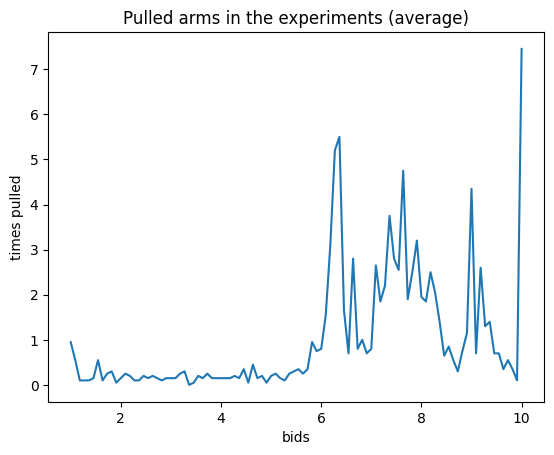

In [ ]:
plt.figure()
plt.title("Pulled arms in the experiments (average)")
plt.plot(bids, gpucb_pulled_arms_counter)
plt.xlabel("bids")
plt.ylabel("times pulled")

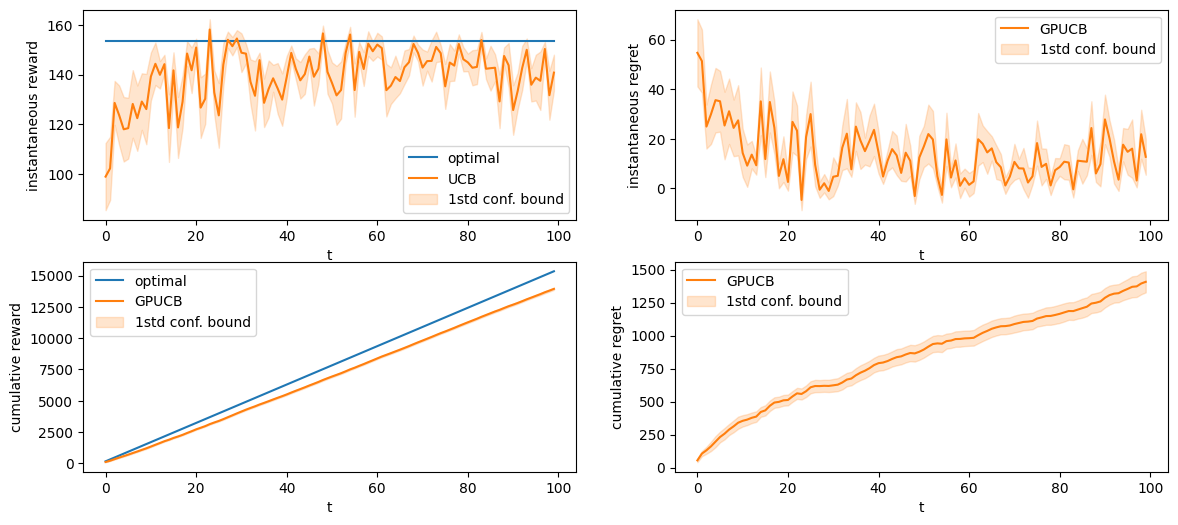

In [ ]:
std_inst = np.std(gpucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(gpucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(gpucb_rewards_per_experiment, axis = 0)

#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std conf. bound")
plt.legend()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "GPUCB")
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std conf. bound")
plt.legend()



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "GPUCB")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std conf. bound")
plt.legend()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "GPUCB")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std conf. bound")
plt.legend()

### Thompson sampling

In [ ]:
## TS learner

n_experiments = 20
gpts_rewards_per_experiment = []

gpts_n_daily_clicks_hat = np.zeros(len(bids))
gpts_n_daily_clicks_std = np.zeros(len(bids))

gpts_cum_daily_costs_hat = np.zeros(len(bids))
gpts_cum_daily_costs_std = np.zeros(len(bids))

# #to count the arms that are pulled
gpts_pulled_arms_counter = np.zeros(len(bids))

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = BiddingEnvironment(bids, C1, sigma_clicks, sigma_costs)
    gpts_learner = Custom_GPTS_Learner(bids)

    rewards_single_experiment = []
    for t in range(0, T):
        pulled_arm = gpts_learner.pull_arm(conversion_rate, margin)
        n_daily_clicks, cum_daily_costs, reward = env.round(margin, conversion_rate, pulled_arm)
        gpts_learner.update(pulled_arm, n_daily_clicks, cum_daily_costs, reward, margin)

        rewards_single_experiment.append(reward)
    gpts_rewards_per_experiment.append(rewards_single_experiment)

    mean_prediction, std_prediction = gpts_learner.clicks_gpts_learner.gp.predict(bids.reshape((-1,1)), return_std=True)
    gpts_n_daily_clicks_hat += mean_prediction / n_experiments
    gpts_n_daily_clicks_std += std_prediction  / n_experiments

    mean_prediction, std_prediction = gpts_learner.costs_gpts_learner.gp.predict(bids.reshape((-1,1)), return_std=True)
    gpts_cum_daily_costs_hat += mean_prediction / n_experiments
    gpts_cum_daily_costs_std += std_prediction  / n_experiments

    # #counting the pulled arms
    gpts_pulled_arms_counter += np.array([gpts_learner.clicks_gpts_learner.pulled_arms_x.count(bid) for bid in bids]) / n_experiments

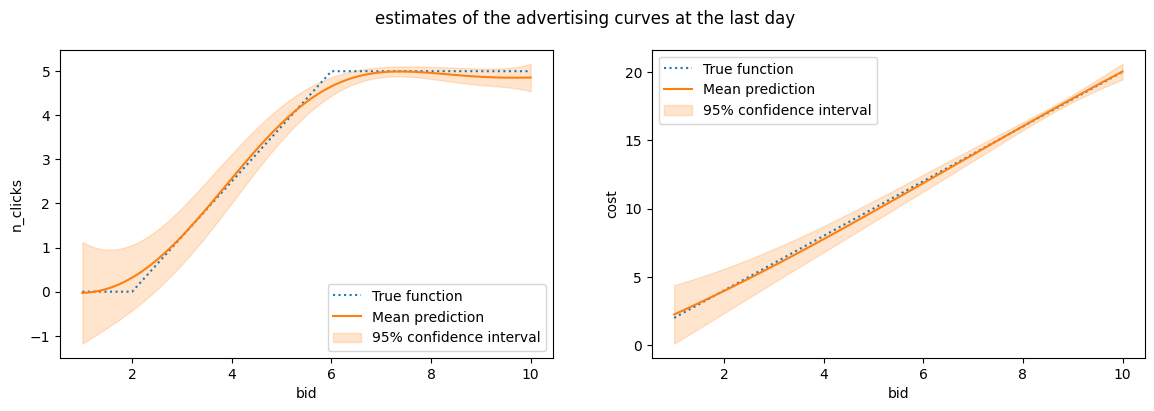

In [ ]:
# Plots of the estimates of the functions clicks and costs at the last day
plt.figure(figsize = (14,4))
plt.suptitle('estimates of the advertising curves at the last day')

plt.subplot(1,2,1)
plt.plot(bids,C1.click_function(bids), linestyle="dotted", label = "True function")
plt.plot(bids, gpts_n_daily_clicks_hat, color = "C1",label="Mean prediction")
plt.fill_between(bids, gpts_n_daily_clicks_hat - 1.96 *gpts_n_daily_clicks_std, gpts_n_daily_clicks_hat + 1.96*gpts_n_daily_clicks_std,
                 alpha = 0.2, color="tab:orange", label=r"95% confidence interval")
plt.xlabel("bid")
plt.ylabel("n_clicks")
plt.legend()

plt.subplot(1,2,2)
plt.plot(bids,C1.cost_function(bids), linestyle="dotted", label = "True function")
plt.plot(bids, gpts_cum_daily_costs_hat, color = "C1",label="Mean prediction")
plt.fill_between(bids, gpts_cum_daily_costs_hat - 1.96 *gpts_cum_daily_costs_std, gpts_cum_daily_costs_hat + 1.96*gpts_cum_daily_costs_std,
                 alpha = 0.2, color="tab:orange", label=r"95% confidence interval")
plt.xlabel("bid")
plt.ylabel("cost")
plt.legend()


In [ ]:
plt.figure()
plt.title("Pulled arms in the experiments (average)")
plt.plot(bids, gpts_pulled_arms_counter)
plt.xlabel("bids")
plt.ylabel("times pulled")
# run again to have this plot

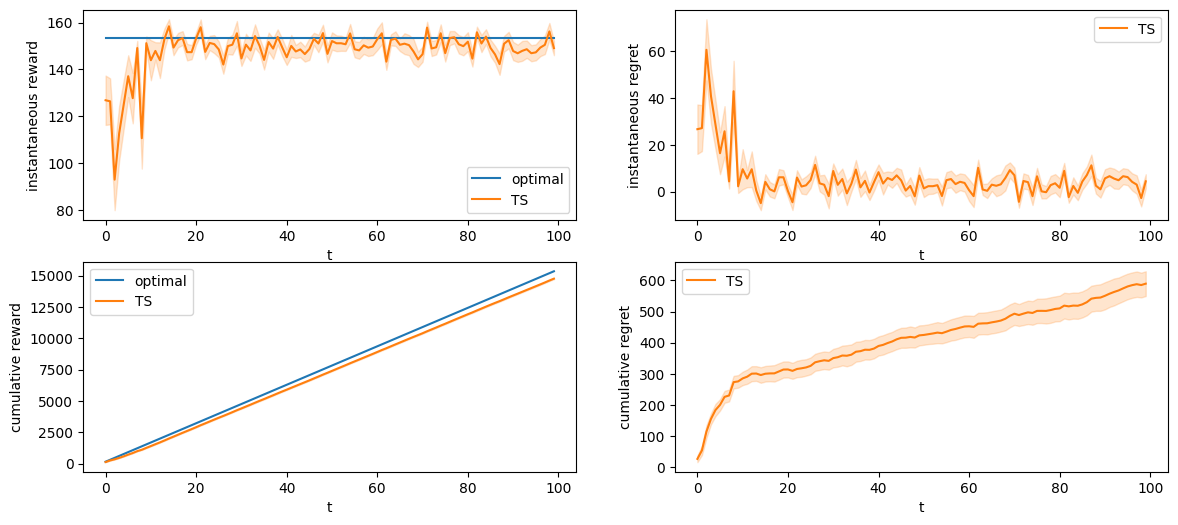

In [ ]:
std_inst = np.std(gpts_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(gpts_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(gpts_rewards_per_experiment, axis = 0)

#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt))
plt.plot(mean_rewards_hat, 'C1')
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1')
plt.legend(["optimal","TS"])

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1')
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1')
plt.legend(["TS"])



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)))
plt.plot(np.cumsum(mean_rewards_hat), 'C1')
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1')
plt.legend(["optimal","TS"])

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1')
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1')
plt.legend(["TS"])

### Plots both methods

In [ ]:
#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt))
plt.plot(np.mean(ucb_rewards_per_experiment, axis = 0), 'b')
plt.plot(np.mean(ts_rewards_per_experiment, axis = 0), 'r')
plt.legend(["optimal","UCB","TS"])

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(np.mean(opt - ucb_rewards_per_experiment, axis = 0), 'b')
plt.plot(np.mean(opt - ts_rewards_per_experiment, axis = 0), 'r')
plt.legend(["UCB","TS"])



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)))
plt.plot(np.cumsum(np.mean(ucb_rewards_per_experiment, axis = 0)), 'b')
plt.plot(np.cumsum(np.mean(ts_rewards_per_experiment, axis = 0)), 'r')
plt.legend(["optimal","UCB","TS"])

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis = 0)), 'b')
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis = 0)), 'r')
plt.legend(["UCB","TS"])

# Step 3

# Step 4

# Step 5

# Step 6